In [1]:
import numpy as np

def CreateNN(nn,dIn=[0],dIntern=[],dOut=[]):
	"""Create Neural Network
	
	Args:
		nn: structure of the NN [I HL1 HL2 ... HLN OL]
			number of layers is the length of the list-1
			number neurons in each layer is the given number
			Example: [2, 3, 4, 1] represents a NN with
				two inputs
				two hidden layers with 3 and 4, respectively
				one linear output layer
		dIn: Time delays for NN inputs. 
			To use only the input of timestep t dIn = [0]
			dIn = [0,1,5] will use inputs of timestep t,t-1 and t-5
		dIntern: Time delays for recurrent internal connections of NN.
			dIntern has to be greater than zero (layer output at timestep t-x)!
			if a non empty list is given, recurrent connection from every
			layer to itself and every layer before is added.
			dIntern = [1,2,5] adds a recurrent connection for the output of
			each layer in timestep t-1,t-2 and t-5
		dOut: Time delays for recurrent connections of output to first hidden layer.
			dOut has to be greater than zero (output at timestep t-x)!
			if a non empty list is given, recurrent connection from NN output
			to first hidden layer is added.
			dOut = [1,3,4] adds a recurrent connection for the output of
			in timestep t-1,t-3 and t-5
	Returns:
		net: untrained neural network
	"""
	
	net = {} #neural network
	delay = {'In':dIn,'Intern':dIntern,'Out':dOut} #Time delays
	net['delay'] = delay #Time delays	
	net['nn'] = nn #structure
	net['M'] = len(nn)-1 #number of layers of the NN
	net['layers'] = nn[1:] #structure without inputs
	net['dmax'] = max(max(dIn,dIntern,dOut)) # maximum time delay	
	net = w_Create(net) #initialize random weight vector and specify sets
	net['w'] = net['w0'].copy() #weight vector used for calculation
	net['N'] = len(net['w0']) #number of weights
	return net
	
def w_Create(net):
	"""	Creates random weight vector of NN and defines sets needed for
		derivative calculation
	
	Args:
		net: neural network
	Returns:
		net: neural network
	"""
	
	M = net['M'] #number of layers
	layers = net['layers'] #NN structure
	delay = net['delay'] #time delays in Network Connections
	inputs = net['nn'][0] #number of inputs
	
	X = []	#set of input layers (input layers or layers with internal delay>0 )
	U = [] 	#set of output layers (output of layer is used for cost function calculation
			# or is added to the input layer with delay>1)
	IW = {}	#input-weight matrices
	LW = {} #LW[m,l,d] connection weight matrix layer m -> layer l with delay d
	b = {} #b[m]: bias vector of layer m
	L_b = {}# L_b[m]: set of layers with a backward connection to layer m
	L_f = {}# L_f[m]: set of layers with a forward connection to layer m
	dL = {}	#dL[m,l]: delays for the connection layer m -> layer l
	CX_LW = {} #CX_LW[u]: set of all input layers, u has a connection to
	CU_LW = {} #CU_LW[x]: set of all output layers, x has a connection to
	b = {} #b[m]: bias vector of layer m
	
	
	'''Inputs'''
	I = {}	#set of inputs with a connection to layer 1
	I[1]=[1] 	#Inputs only connect to layer 1
	
	dI={}	#Delays for connection of input to layer 1
	dI[1,1] = delay['In']
	for d in dI[1,1]:
		IW[1,1,d] = np.random.rand(layers[0],inputs)-0.5 	#input-weight matrix
														#random values [-0.5,0.5]
	X.append(1) 	#first layer is input layer
	
	'''Internal Connection Weight Matrices'''
	for m in range(1,M+1):
		L_b[m] = [] #L_b[m]: Set of layers that have a backward connection to layer m
		L_f[m] = [] #L_f[m]: Set of layers that have a forward connection to layer m
			
		#Forward Connections
		if m>1:
			l=m-1
			dL[m,l]=[0] #no delay for forward connections
			LW[m,l,0] = np.random.rand(layers[m-1],layers[l-1])-0.5 #connection weight matrix
			L_b[l].append(m) #layer m has backward connection to layer l
			L_f[m].append(l) #layer l has forward connection to layer m
	
		#Recursive Connections
		for l in range(m,M+1):
			if (m==1)and(l==M):
			#special case delay form output to layer 1
				dL[m,l]=delay['Out'] #delays from output to first layer
			else:
				dL[m,l]=delay['Intern'] #internal delays
				
			for d in dL[m,l]:
			#all delays for connection l->m
				LW[m,l,d] = np.random.rand(layers[m-1],layers[l-1])-0.5 #connection weight matrix
				if (l not in L_f[m]):
					#add to L_f[m] if not yet done
					L_f[m].append(l) #layer l has forward connection to layer m
				if (l>=m) and(d>0):
				#if it is a recurrent connection
					if (m not in X):
					#and m is not yet in X
						X.append(m) #add m to input layers
					if (l not in U):
					#and l is not yet in U
						U.append(l) #add l to output layers
		
		
		b[m] = np.random.rand(layers[m-1])-0.5#create bias vector for layer m
	
	if M not in U:
		U.append(M) # #add M to output layers if not yet done
		
	for u in U:
		CX_LW[u] = []
		for x in X:
			if (u in L_f[x]) and (np.any(np.array(dL[x,u])>0)) and (x not in CX_LW[u]):
				#if u in L_f[x] and connection x->u has delay>0 and x is not yet in CX_LW[u]
				CX_LW[u].append(x) #add u
	for x in range(1,M+1):
		CU_LW[x] = []
		for u in U:
			try:
				if np.any(np.array(dL[x,u])>0):
				# if connection u -> x has delay >0
					CU_LW[x].append(u)
			except KeyError:
				pass
	#Add to NN
	net['U'] = U
	net['X'] = X
	net['dL'] = dL
	net['dI'] = dI
	net['L_b'] = L_b
	net['L_f'] = L_f
	net['I']=I
	net['CX_LW'] = CX_LW
	net['CU_LW'] = CU_LW
	net['w0'] = Wb2w(net,IW,LW,b)
	return net
	
def Wb2w(net,IW,LW,b):
	"""	Converts Input Weight matrices IW, connection weight matrices LW
		and bias vectors b to weight vector w
	
	Args:
		net: 	neural network
		IW		input-weight matrices
		LW 		LW[m,l,d] connection weight matrix layer m -> layer l with delay d		b		b[m]: bias vector of layer m			
	Returns:
		w: 		weight vector
	"""
	
	dL = net['dL'] #dL[m,l]: delays for the connection layer m -> layer l
	dI = net['dI'] #Delays for connection of input to layer 1
	I = net['I'] #set of inputs with a connection to layer 1
	L_f = net['L_f'] # L_f[m]: set of layers with a forward connection to layer m
	M = net['M'] #number of layers of NN
	
	w = np.array([]) #empty weight vector
	
	for m in range(1,M+1):
		#input weights
		if m==1:
			for i in I[m]:
				for d in dI[m,i]:
					w = np.append(w,IW[m,i,d].flatten('F'))
		#internal connection weights
		for l in L_f[m]:
			for d in dL[m,l]:
				w = np.append(w,LW[m,l,d].flatten('F'))
		#bias weights
		w = np.append(w,b[m])
	
	return w
	
def w2Wb(net):
	"""	Converts weight vector w to Input Weight matrices IW, connection weight matrices LW
		and bias vectors b
	
	Args:
		net: 	neural network (containing weight vector w)		
	Returns:
		IW		input-weight matrices
		LW 		LW[m,l,d] connection weight matrix layer m -> layer l with delay d		b		b[m]: bias vector of layer m	
	"""
	
	dL = net['dL'] #dL[m,l]: delays for the connection layer m -> layer l
	dI = net['dI'] #Delays for connection of input to layer 1
	I = net['I'] #set of inputs with a connection to layer 1
	L_f = net['L_f'] # L_f[m]: set of layers with a forward connection to layer m
	M = net['M'] #number of layers of NN
	layers = net['layers'] #structure of the NN
	inputs = net['nn'][0] #number of inputs
	w_temp = net['w'].copy() #weight vector
		
	IW = {}	#input-weight matrices
	LW = {} #LW[m,l,d] connection weight matrix layer m -> layer l with delay d
	b = {} #b[m]: bias vector of layer m
	
	for m in range(1,M+1):
	
		#input weights
		if m==1:
			for i in I[m]:
				for d in dI[m,i]:
					w_i = inputs*layers[m-1]
					vec =w_temp[0:w_i]
					w_temp = w_temp[w_i:]
					IW[m,i,d] = np.reshape(vec,(layers[m-1],int(len(vec)/layers[m-1])),order='F')
		
		#internal connection weights
		for l in L_f[m]:
			for d in dL[m,l]:
				w_i = layers[l-1]*layers[m-1]
				vec =w_temp[0:w_i]
				w_temp = w_temp[w_i:]
				LW[m,l,d] = np.reshape(vec,(layers[m-1],int(len(vec)/layers[m-1])),order='F')
		
		#bias weights
		w_i = layers[m-1]
		b[m] =w_temp[0:w_i]
		w_temp = w_temp[w_i:]

	return IW,LW,b


def NNOut_(P,net,IW,LW,b,a={},q0=0):
	"""	Calculates NN Output for given Inputs P
		For internal use only
	
	Args:
		P:		NN Inputs
		net: 	neural network
		IW:		input-weight matrices
		LW:		LW[m,l,d] connection weight matrix layer m -> layer l with delay d		b:		b[m]: bias vector of layer m
		a:		Layer Outputs of NN. for use of known historical data
		q0:		Use data starting from datapoint q0 P[q0:]
	Returns:
		Y_NN: 	Neural Network output for input P
		a:		Layer Outputs of NN
		n:		sum output of layers
	"""
	
	dL = net['dL'] #dL[m,l]: delays for the connection layer m -> layer l
	dI = net['dI'] #Delays for connection of input to layer 1
	I = net['I'] #set of inputs with a connection to layer 1
	L_f = net['L_f'] # L_f[m]: set of layers with a forward connection to layer m
	M = net['M'] #number of layers of NN
	outputs = net['nn'][-1] #number of outputs
	
	n = {} #sum output of layers
	Q = P.shape[1] #number of input datapoints

		
	Y_NN = np.zeros((outputs,Q)) #NN Output
	
	for q in range(q0+1,Q+1):
	#for all datapoints
		a[q,1]=0
		for m in range(1,M+1):
		#for all layers m
			n[q,m]=0 #sum output datapoint q, layer m
			
			#input weights
			if m==1:
				for i in I[m]:
					for d in dI[m,i]:
						if (q-d)>0:
							n[q,m]=n[q,m]+np.dot(IW[m,i,d],P[:,q-d-1])
			#connection weights
			for l in L_f[m]:
				for d in dL[m,l]:
					if (q-d)>0:
						n[q,m]=n[q,m]+np.dot(LW[m,l,d],a[q-d,l])
			#bias
			n[q,m]=n[q,m] + b[m]
			
			#Calculate layer output
			if m==M:
				a[q,M]=n[q,M] #linear layer for output
			else:
				a[q,m] = np.tanh(n[q,m])
		Y_NN[:,q-1]=a[q,M]
	Y_NN = Y_NN[:,q0:]
	return Y_NN,n,a
	
def NNOut(P,net,P0=None,Y0=None):
	"""	Calculates NN Output for given Inputs P
		User Function

	Args:
		P:		NN Inputs
		net: 	neural network
		P0:		previous input Data
		Y0:		previous output Data
	Returns:
		Y_NN: 	Neural Network output for input P
	"""
	Y=np.zeros((net['layers'][-1],int(np.size(P)/net['nn'][0])))
	data,net = prepare_data(P,Y,net,P0=P0,Y0=Y0)
	IW,LW,b = w2Wb(net) #input-weight matrices,connection weight matrices, bias vectors
	Y_NN = NNOut_(data['P'],net,IW,LW,b,a=data['a'],q0=data['q0'])[0]
	
	#scale normalized Output
	Y_NN_scaled = Y_NN.copy()
	for y in range(np.shape(Y_NN)[0]):
		Y_NN_scaled[y] = Y_NN[y]*net['normY'][y]
	
	if np.shape(Y_NN_scaled)[0]==1:
		Y_NN_scaled=Y_NN_scaled[0]
	return Y_NN_scaled
	
	
def RTRL(net,data):
	"""	Implementation of the Real Time Recurrent Learning Algorithm based on:
		Williams, Ronald J.; Zipser, David: A Learning Algorithm for Continually Running
		Fully Recurrent Neural Networks. In: Neural Computation, Nummer 2, Vol. 1
		(1989), S. 270-280.
		
	Args:
		net:	neural network
		data: 	Training Data
	Returns:
		J: 		Jacobian Matrix. derivatives of e with respect to the weight vector w
		E:		Mean squared Error of the Neural Network compared to Training data
		e:		error vector: difference of NN Output and target data['Y']
	"""
	P = data['P']	#Training data Inputs
	Y = data['Y']	#Training data Outputs
	a = data['a']	#Layer Outputs
	q0 = data['q0']	#Use training data [q0:]
	
	
	dL = net['dL'] #dL[m,l]: delays for the connection layer m -> layer l
	dI = net['dI'] #Delays for connection of input to layer 1
	I = net['I'] #set of inputs with a connection to layer 1
	L_f = net['L_f'] # L_f[m]: set of layers with a forward connection to layer m
	L_b = net['L_b'] # L_f[m]: set of layers with a forward connection to layer m
	M = net['M'] #number of layers of NN
	inputs = net['nn'][0] #number of inputs
	outputs = net['nn'][-1] #number of outputs
	layers = net['layers'] #structure of the NN
	max_delay  = net['dmax'] # Maximum delay in the NN
	U = net['U'] #set of input layers (input layers or layers with internal delay>0 )
	X = net['X'] #set of output layers (output of layer is used for cost function calculation
			# or is added to the input layer with delay>1)
	CU_LW = net['CU_LW'] #CU_LW[x]: set of all output layers, x has a connection to		
	IW,LW,b = w2Wb(net) #input-weight matrices,connection weight matrices, bias vectors
	
	########################
	# 1. Calculate NN Output
	Y_NN,n,a = NNOut_(P,net,IW,LW,b,a=a,q0=q0)
	
	########################
	# 2. Calculate Cost function E
	Y_delta = Y - Y_NN #error matrix
	e = np.reshape(Y_delta,(1,np.size(Y_delta)),order='F')[0] #error vector
	E = np.dot(e,e.transpose()) #Cost function (mean squared error)
	
	#########################
	# 3. Backpropagation RTRL
	
	Q = P.shape[1] #number of input datapoints
	Q0 = Q-q0 #number of datapoints without "old data"
	
	#Definitions
	dAu_db = {}		#derivative of layer output a(u) with respect to bias vector b
	dAu_dIW = {}	#derivative of layer output a(u) with respect to input weights IW
	dAu_dLW = {}	#derivative of layer output a(u) with respect to connections weights LW
	dA_dw = {}		#derivative of layer outputs a with respect to weight vector w
	S = {}			#Sensitivity Matrix
	Cs = {}			#Cs[u]: Set of layers m with an existing sensitivity matrix S[q,u,m]
	CsX = {}		#CsX[u]: Set of input layers x with an existing sensitivity matrix
					#S[q,u,x]
					#Cs and CsX are generated during the Backpropagation
			
	#Initialize
	J = np.zeros((Q0*layers[-1],net['N']))	#Jacobian matrix
	for q in range(1,q0+1):
		for u in U:
			dAu_dLW[q,u] = np.zeros((layers[u-1],net['N']))
	
	###
	#Begin RTRL
	for q in range(q0+1,Q+1):
	
		#Initialize
		U_ = [] #set needed for calculating sensitivities
		for u in U:
			Cs[u] = []
			CsX[u] = []
			dA_dw[q,u] = 0
			
		#Calculate Sensitivity Matrices
		for m in range(M,1-1,-1):
		# decrement m in backpropagation order
		
			for u in U_:
				S[q,u,m] = 0 #Sensitivity Matrix layer u->m
				for l in L_b[m]:
					S[q,u,m] = S[q,u,m] \
						+ np.dot(np.dot(S[q,u,l],LW[l,m,0]),np.diag(1-(np.tanh(n[q,m]))**2))
						#recursive calculation of Sensitivity Matrix layer u->m
				if m not in Cs[u]:
					Cs[u].append(m) #add m to set Cs[u]
					if m in X:
						CsX[u].append(m) #if m ind X, add to CsX[u]
			
			if m in U:
				if m==M:
					#output layer is linear, no transfer function
					S[q,m,m] = np.diag(np.ones(outputs)) #Sensitivity Matrix S[M,M]
				else:
					S[q,m,m] = np.diag(1-(np.tanh(n[q,m]))**2) #Sensitivity Matrix S[m,m]
				
				U_.append(m) #add m to U'
				Cs[m].append(m) #add m to Cs
				if m in X:
					CsX[m].append(m) #if m ind X, add to CsX[m]
		
		#Calculate derivatives
		for u in sorted(U):
			#static derivative calculation
			dAe_dw = np.empty((layers[u-1],0)) #static derivative vector: explicit derivative layer outputs with respect to weight vector
			for m in range(1,M+1):
				#Input weights
				if m==1:
					for i in I[m]:
						for d in dI[m,i]:
							if ((q,u,m) not in S.keys()) or (d>=q):
							#if no sensivity matrix exists or d>=q: derivative is zero
								dAu_dIW[m,i,d] = \
									np.kron(P[:,q-d-1].transpose(),\
											np.zeros((layers[u-1],layers[m-1])))
							else:
								#derivative output layer u with respect to IW[m,i,d]
								dAu_dIW[m,i,d] = \
									np.kron(P[:,q-d-1].transpose(),S[q,u,m])
							dAe_dw = np.append(dAe_dw,dAu_dIW[m,i,d],1) #append to static derivative vector
	
				#Connection weights
				for l in L_f[m]:
					for d in dL[m,l]:
						if ((q,u,m) not in S.keys()) or (d>=q):
						#if no sensivity matrix exists or d>=q: derivative is zero
							dAu_dLW[m,l,d] = \
								np.kron(a[q,l].transpose(),\
										np.zeros((layers[u-1],layers[m-1])))
						else:
							dAu_dLW[m,l,d] = \
								np.kron(a[q-d,l].transpose(),S[q,u,m])
								#derivative output layer u with respect to LW[m,i,d]
						dAe_dw = np.append(dAe_dw,dAu_dLW[m,l,d],1) #append to static derivative vector
				
				#Bias weights
				if ((q,u,m) not in S.keys()):
					dAu_db[m] = np.zeros((layers[u-1],layers[m-1])) #derivative is zero
				else:
					dAu_db[m] = S[q,u,m] #derivative output layer u with respect to b[m]
				dAe_dw = np.append(dAe_dw,dAu_db[m],1) #append to static derivative vector
				
			#dynamic derivative calculation
			dAd_dw=0 #dynamic derivative, sum of all x
			for x in CsX[u]:
				sum_u_ = 0 #sum of all u_
				for u_ in CU_LW[x]:
					sum_d = 0 #sum of all d
					for d in dL[x,u_]:
						if (q-d>0)and(d>0):
						#delays >0 and <q
							sum_d = sum_d + np.dot(LW[x,u_,d],dA_dw[q-d,u_])
					sum_u_ = sum_u_+sum_d
				if sum_u_ is not 0:
					dAd_dw = dAd_dw + np.dot(S[q,u,x],sum_u_) #sum up dynamic derivative
					
			#static + dynamic derivative
			dA_dw[q,u] = dAe_dw + dAd_dw # total derivative output layer u with respect to w
			
		# Jacobian Matrix
		J[range(((q-q0)-1)*outputs,(q-q0)*outputs),:] = -dA_dw[q,M]
		
		# Delete entries older than q-max_delay in dA_dw
		if q > max_delay:
			new_dA_dw = dict(dA_dw)
			for key in dA_dw.keys():
				if key[0] == q-max_delay:
					del new_dA_dw[key]
			dA_dw = new_dA_dw
		
		# Reset S
		S = {}
		
	return J,E,e

def BPTT(net,data):
	"""	Implementation of the Back Propagation Through Time Algorithm based on:
		Werbos, Paul: Backpropagation through time: what it does and how to do it. In:
		Proceedings of the IEEE, Nummer 10, Vol. 78 (1990), S. 1550-1560.
		
	Args:
		net:	neural network
		data: 	Training Data
	Returns:
		g: 		gradient vector. derivatives of the Error E with respect to the weight vector 
		E:		Mean squared Error of the Neural Network compared to Training data
	"""

	P = data['P']	#Training data Inputs
	Y = data['Y']	#Training data Outputs
	a = data['a']	#Layer Outputs
	q0 = data['q0']	#Use training data [q0:]
	
	
	dL = net['dL'] #dL[m,l]: delays for the connection layer m -> layer l
	dI = net['dI'] #Delays for connection of input to layer 1
	I = net['I'] #set of inputs with a connection to layer 1
	L_f = net['L_f'] # L_f[m]: set of layers with a forward connection to layer m
	L_b = net['L_b'] # L_f[m]: set of layers with a forward connection to layer m
	M = net['M'] #number of layers of NN
	inputs = net['nn'][0] #number of inputs
	outputs = net['nn'][-1] #number of outputs
	layers = net['layers'] #structure of the NN
	U = net['U'] #set of input layers (input layers or layers with internal delay>0 )
	X = net['X'] #set of output layers (output of layer is used for cost function calculation
			# or is added to the input layer with delay>1)
	CX_LW = net['CX_LW'] #CX_LW[u]: set of all input layers, u has a connection to
	IW,LW,b = w2Wb(net) #input-weight matrices,connection weight matrices, bias vectors
	
	########################
	# 1. Calculate NN Output
	Y_NN,n,a = NNOut_(P,net,IW,LW,b,a=a,q0=q0)
	
	########################
	# 2. Calculate Cost function E
	Y_delta = Y - Y_NN #error matrix
	e = np.reshape(Y_delta,(1,np.size(Y_delta)),order='F')[0] #error vector
	E = np.dot(e,e.transpose()) #Cost function (mean squared error)
	
	#########################
	# 3. Backpropagation Through Time
	
	Q = P.shape[1] #number of input datapoints
	Q0 = Q-q0 #number of datapoints without "old data"
	
	#Definitions
	S = {}			#Sensitivity Matrix
	dE_dIW = {}	#derivative of Error E with respect to input weights IW
	dE_dLW = {}	#derivative of Error E with respect to connections weights LW
	dE_db = {}	#derivative of Error E with respect to bias vector b
	dEs_dAu = {}	#static derivative of Error E with respect to layer outputs
	dEd_dAu = {}	#dynamic derivative of Error E with respect to layer outputs
	dE_dAu = {}		#total derivative of Error E with respect to layer outputs
	CsU = {}	#CsU[x]: Set of all u in U, with existing S{q,u,x}
	
	###
	#Begin BPTT
	for q in range(Q,q0,-1):
	
		#Initialize
		U_ = [] #set needed for calculating sensitivities
		for x in range(1,M+1):
			CsU[x] = []
			
		#Calculate Sensitivity Matrices
		for m in range(M,1-1,-1):
		# decrement m in backpropagation order
		
			for u in U_:
				S[q,u,m] = 0 #Sensitivity Matrix layer u->m
				for l in L_b[m]:
					S[q,u,m] = S[q,u,m] \
						+ np.dot(np.dot(S[q,u,l],LW[l,m,0]),np.diag(1-(np.tanh(n[q,m]))**2))
						#recursive calculation of Sensitivity Matrix layer u->m
				if u not in CsU[m]:
					CsU[m].append(u) #add u to set CsU[m]
			
			if m in U:
				if m==M:
					#output layer is linear, no transfer function
					S[q,m,m] = np.diag(np.ones(outputs)) #Sensitivity Matrix S[M,M]
				else:
					S[q,m,m] = np.diag(1-(np.tanh(n[q,m]))**2) #Sensitivity Matrix S[m,m]
				if m not in U_:
					U_.append(m) #add m to U'
				if m not in CsU[m]:
					CsU[m].append(m) #add to CsU[m]
		
		#Calculate derivatives dE/dA with respect to the layer outputs
		for u in sorted(U,reverse=True):
		#decrement U in backpropagation order
		
			#static derivative calculation
			if u==M:
				dEs_dAu[u] = -2*(Y_delta[:,q-1]) #derivative for output layer
			else:
				#static derivative is zero for non-output layers
				dEs_dAu[u]= 0*np.dot(np.dot(LW[u+1,u,0].transpose(),S[q,M,u+1].transpose())\
									,dEs_dAu[M])
			
			#dynamic derivative calculation
			dEd_dAu[u]=0
			for x in CX_LW[u]:
				sum_d=0
				for d in dL[x,u]:
					if d<=Q-q:
						sum_u_= 0
						for u_ in CsU[x]:
							#dynamic derivative calculation part 1 (sum of all u_)
							sum_u_ = sum_u_ + np.dot(S[q+d,u_,x].transpose(),dE_dAu[q+d,u_])
						#dynamic derivative calculation part 2 (sum of all d)	
						sum_d=sum_d+ np.dot(LW[x,u,d].transpose(),sum_u_)
				#dynamic derivative calculation part 3 (sum of all x)		
				dEd_dAu[u]=dEd_dAu[u]+sum_d
				
			#dotal derivative calculation, dynamic + static
			dE_dAu[q,u]=dEs_dAu[u]+dEd_dAu[u]	
				
		#Calculate derivatives dE/dw with respect to the weights
		dm = {}	#auxiliary derivative 
		for m in range(1,M+1):
		
			dm[m] = 0
			for u in CsU[m]:
				dm[m] = dm[m] + np.dot(S[q,u,m].transpose(),dE_dAu[q,u])
				
			#Input weights
			if m==1:
				for i in I[m]:
					for d in dI[m,i]:
						if q-d>0:
							#calculate derivative of Error E with respect to input weights IW
							dE_dIW[m,i,d] = np.dot(np.matrix(dm[m]).transpose(),np.matrix(P[:,q-d-1]))
						else:
							dE_dIW[m,i,d] = 0 * IW[m,i,d] #derivative is zero
							
			#Connection weights
			for l in L_f[m]:
				for d in dL[m,l]:
					if q-d>0:
						#calculate derivative of Error E with respect to connections weights LW
						dE_dLW[m,l,d] = np.dot(np.matrix(dm[m]).transpose(),np.matrix(a[q-d,l]))

					else:
						dE_dLW[m,l,d] = 0*LW[m,l,d] #derivative is zero
			
			#Bias weights
			dE_db[m] = dm[m] #calculate derivative of Error E with respect to bias vector b
		
		#gradient for datapoint q
		dE_dw = Wb2w(net,dE_dIW,dE_dLW,dE_db)#convert derivative matrices to derivative vector
		
		#total gradient is sum of all datapoint gradients
		if q==Q:
			#first datapoint
			g = dE_dw
		else:
			g = g+dE_dw
			
	return g,E

	
def train_LM(P,Y,net,k_max=100,E_stop=1e-10,dampfac=3.0,dampconst=10.0,\
			verbose = False,min_E_step=1e-09):
	"""	Implementation of the Levenberg-Marquardt-Algorithm (LM) based on:
		Levenberg, K.: A Method for the Solution of Certain Problems in Least Squares.
		Quarterly of Applied Mathematics, 2:164-168, 1944.
		and
		Marquardt, D.: An Algorithm for Least-Squares Estimation of Nonlinear Parameters.
		SIAM Journal, 11:431-441, 1963.
		
	Args:

		P:		NN Inputs
		Y:		NN Targets
		net: 	neural network
		k_max:	maxiumum number of iterations
		E_stop:	Termination Error, Training stops when the Error <= E_stop
		dampconst:	constant to adapt damping factor of LM
		dampfac:	damping factor of LM
		min_E_step: minimum step for error. When reached 5 times, training terminates.        
	Returns:
		net: 	trained Neural Network 
	"""
	#create data dict
	data,net = prepare_data(P,Y,net)
	
	#Calculate Jacobian, Error and error vector for first iteration
	J,E,e = RTRL(net,data)
	k = 0
	ErrorHistory=np.zeros(k_max+1) #Vektor for Error hostory
	ErrorHistory[k]=E
	if verbose:
		print('Iteration: ',k,'		Error: ',E,'	scale factor: ',dampfac)
	
	early=0

	while True:
	#run loop until either k_max or E_stop is reached

		JJ = np.dot(J.transpose(),J) #J.transp * J
		w = net['w'] #weight vector
		while True:
		#repeat until optimizing step is successful
			#gradient
			g = np.dot(J.transpose(),e)
			
			#calculate scaled inverse hessian
			try:
				G = np.linalg.inv(JJ+dampfac*np.eye(net['N'])) #scaled inverse hessian
			except np.linalg.LinAlgError:
				# Not invertible. Go small step in gradient direction
				w_delta = 1.0/1e10 * g
			else:
				# calculate weight modification
				w_delta = np.dot(-G,g)
			
			net['w'] = w + w_delta #new weight vector
			
			Enew = calc_error(net,data) #calculate new Error E			
			if Enew<E and abs(E-Enew)>=min_E_step:
			#Optimization Step successful!
				dampfac= dampfac/dampconst#adapt scale factor
				early=0 #reset the early stopping criterium
				break #go to next iteration
			else:
			#Optimization Step NOT successful!\
				dampfac = dampfac*dampconst#adapt scale factor
				if abs(E-Enew)<=min_E_step:
					early=early+1
					
					if verbose:
						print('E-Enew<=min_E_step Encountered!!')
						if early>=5.0:
							print('5 Times * E-Enew<=min_E_step Encountered!!')
					break                    
		
		#Calculate Jacobian, Error and error vector for next iteration
		J,E,e = RTRL(net,data)
		k = k+1
		ErrorHistory[k] = E
		if verbose:
			print('Iteration: ',k,'		Error: ',E,'	scale factor: ',dampfac)
	
		#Ceck if termination condition is fulfilled
		if k>=k_max:
			print('Maximum number of iterations reached')
			break
		elif E<=E_stop:
			print('Termination Error reached')
			break
		elif early>=5.0:
			print('Error decreased 5 times by minimum step. Force training exit.')
			break
        
	net['ErrorHistory'] = ErrorHistory[:k]
	return net
	
	
def calc_error(net,data):
	"""	Calculate Error for NN based on data
		
	Args:
		net:	neural network
		data: 	Training Data
	Returns:
		E:		Mean squared Error of the Neural Network compared to Training data
	"""
	P = data['P']	#Training data Inputs
	Y = data['Y']	#Training data Outputs
	a = data['a']	#Layer Outputs
	q0 = data['q0']	#Use training data [q0:]
	
	IW,LW,b = w2Wb(net) #input-weight matrices,connection weight matrices, bias vectors
	
	########################
	# 1. Calculate NN Output
	Y_NN,n,a = NNOut_(P,net,IW,LW,b,a=a,q0=q0)
	
	########################
	# 2. Calculate Cost function E
	Y_delta = Y - Y_NN #error matrix
	e = np.reshape(Y_delta,(1,np.size(Y_delta)),order='F')[0] #error vector
	E = np.dot(e,e.transpose()) #Cost function (mean squared error)
	
	return E
	
def prepare_data(P,Y,net,P0=None,Y0=None):
	"""	Prepare Input Data for the use for NN Training and check for errors
		
	Args:
		P:		neural network Inputs
		Y: 		neural network Targets
		net: 	neural network
		P0:		previous input Data
		Y0:		previous output Data
	Returns:
		data:	dict containing data for training or calculating putput
	"""	
	
	#Convert P and Y to 2D array, if 1D array is given
	if P.ndim==1:
		P = np.array([P])
	if Y.ndim==1:
		Y = np.array([Y])
		
	#Ceck if input and output data match structure of NN	
	if np.shape(P)[0] != net['nn'][0]:
		raise ValueError("Dimension of Input Data does not match number of inputs of the NN")
	if np.shape(Y)[0] != net['nn'][-1]:
		raise ValueError("Dimension of Output Data does not match number of outputs of the NN")
	if np.shape(P)[1] != np.shape(Y)[1]:
		raise ValueError("Input and output data must have same number of datapoints Q")
	
	#check if previous data is given
	if (P0 is not None) and (Y0 is not None):

		#Convert P and Y to 2D array, if 1D array is given
		if P0.ndim==1:
			P0 = np.array([P0])
		if Y0.ndim==1:
			Y0 = np.array([Y0])
			
		#Ceck if input and output data match structure of NN
		if np.shape(P0)[0] != net['nn'][0]:
			raise ValueError("Dimension of previous Input Data P0 does not match number of inputs of the NN")
		if np.shape(Y0)[0] != net['nn'][-1]:
			raise ValueError("Dimension of previous Output Data Y0 does not match number of outputs of the NN")
		if np.shape(P0)[1] != np.shape(Y0)[1]:
			raise ValueError("Previous Input and output data P0 and Y0 must have same number of datapoints Q0")

		q0 = np.shape(P0)[1]#number of previous Datapoints given 
		a = {} #initialise layer outputs
		for i in range(1,q0+1):
			for j in range(1,net['M']):
				a[i,j]=np.zeros(net['nn'][j]) #layer ouputs of hidden layers are unknown -> set to zero
			a[i,net['M']]=Y0[:,i-1]/net['normY'] #set layer ouputs of output layer

		#add previous inputs and outputs to input/output matrices
		P_ = np.concatenate([P0,P],axis=1)
		Y_ = np.concatenate([Y0,Y],axis=1)
	else:
		#keep inputs and outputs as they are and set q0 and a to default values
		P_ = P.copy()
		Y_ = Y.copy()
		q0=0
		a={}
	#normalize
	P_norm = P_.copy()
	Y_norm = Y_.copy()
	if 'normP' not in net.keys():
		normP = np.ones(np.shape(P_)[0])
		for p in range(np.shape(P_)[0]):
			normP[p] = np.max([np.max(np.abs(P_[p])),1.0])
			P_norm[p] = P_[p]/normP[p]
		normY = np.ones(np.shape(Y_)[0])
		for y in range(np.shape(Y_)[0]):
			normY[y] = np.max([np.max(np.abs(Y_[y])),1.0])
			Y_norm[y] = Y_[y]/normY[y]
		net['normP'] = normP
		net['normY'] = normY
	else:
		for p in range(np.shape(P_)[0]):
			P_norm[p] = P_[p]/net['normP'][p]
		normY = np.ones(np.shape(Y)[0])
		for y in range(np.shape(Y_)[0]):
			Y_norm[y] = Y_[y]/net['normY'][y]
		
	#Create data dict
	data = {}		
	data['P'] = P_norm
	data['Y'] = Y_norm
	data['a'] = a
	data['q0'] = q0
	
	return data,net

def saveNN(net,filename):
	"""	Save neural network object to file
		
	Args:
		net: 	neural network object
		filename:	path of csv file to save neural network
	
	"""	
	import csv
	import pandas as pd
	
	#create csv write
	file = open(filename,"w")
	writer = csv.writer(file, lineterminator='\n')

	
	#write network structure nn
	writer.writerow(['nn'])
	writer.writerow(net['nn'])
	
	#write input delays dIn
	writer.writerow(['dIn'])
	writer.writerow(net['delay']['In'])
	
	#write internal delays dIntern
	writer.writerow(['dIntern'])
	if not net['delay']['Intern']:
		writer.writerow(['',''])
	else:
		writer.writerow(net['delay']['Intern'])
		
	#write output delays dIOut
	writer.writerow(['dOut'])
	if not net['delay']['Out']:
		writer.writerow(['',''])
	else:
		writer.writerow(net['delay']['Out'])
		
	#write factor for input data normalization normP
	writer.writerow(['normP'])
	writer.writerow(net['normP'])
	
	#write factor for output data normalization normY
	writer.writerow(['normY'])
	writer.writerow(net['normY'])
	
	#write weight vector w
	writer.writerow(['w'])
	file.close()
	
	file = open(filename,"ab")
	np.savetxt(file,net['w'],delimiter=',',fmt='%.55f')
	
	#close file
	file.close()
	
	return
	
def loadNN(filename):
	"""	Load neural network object from file
		
	Args:
		filename:	path to csv file to save neural network
	Returns:
		net: 	neural network object
	"""	
	import csv
	import pandas as pd
	
	#read csv
	data= list(csv.reader(open(filename,"r")))

	#read network structure nn
	nn = list(np.array(data[1],dtype=np.int))
	
	#read input delays dIn
	dIn = list(np.array(data[3],dtype=np.int))
	
	#read internal delays dIntern
	if data[5] == ['','']:
		dIntern = []
	else:
		dIntern = list(np.array(data[5],dtype=np.int))
		
	#read output delays dIOut
	if data[7] == ['','']:
		dOut = []
	else:
		dOut = list(np.array(data[7],dtype=np.int))
	
	#read factor for input data normalization normP
	normP = np.array(data[9],dtype=np.float)
	
	#read factor for output data normalization normY
	normY = np.array(data[11],dtype=np.float)
	
	#read weight vector w
	w = pd.read_csv(filename,sep=',',skiprows=range(12))['w'].values
	
	#Create neural network and assign loaded weights and factors
	net = CreateNN(nn,dIn,dIntern,dOut)
	net['normP'] = normP
	net['normY'] = normY
	net['w'] = w
	
	return net


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [78]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 1AC9-90D3

 Directory of C:\Users\admin\Desktop\data_dos

05/27/2021  11:39 AM    <DIR>          .
05/27/2021  11:39 AM    <DIR>          ..
05/27/2021  02:33 AM    <DIR>          .ipynb_checkpoints
05/27/2021  02:42 AM            17,634 Book1.csv
05/27/2021  12:21 AM         6,109,592 dos_inputtest - Copy.csv
05/27/2021  12:36 AM        46,634,289 dos_inputtrain - Copy.csv
05/27/2021  02:32 AM            94,925 example_data.csv
05/27/2021  12:44 AM            98,187 label_test.csv
05/27/2021  12:42 AM           763,330 label_train.csv
05/27/2021  12:46 AM    <DIR>          New folder
05/27/2021  11:39 AM           121,096 PCA.ipynb
05/27/2021  11:39 AM           460,429 test.ipynb
               8 File(s)     54,299,482 bytes
               4 Dir(s)  14,589,739,008 bytes free


In [93]:
df = pd.read_csv('Book1.csv')

In [80]:
df

Unnamed: 0  P1  P2   P3     Y1      Y2  P1test  P2test  P3test  Y1test  \
0             1   1   0  0.7   7.00  21.600       1       0     0.7   7.000   
1             2   1   0  0.7  10.75  23.475       1       0     0.7  10.750   
2             3   0   0  0.7  14.50   7.600       1       0     0.7  14.500   
3             4   0   0  0.7  14.50   7.600       1       0     0.7  18.250   
4             5   0   0  0.7  14.50   7.600       1       0     0.7  22.000   
..          ...  ..  ..  ...    ...     ...     ...     ...     ...     ...   
475         476   0   0  0.7   7.00   7.600       1       0     0.7  30.875   
476         477   0   0  0.7   7.00   7.600       1       0     0.7  34.625   
477         478   0   0  0.7   7.00   7.600       1       0     0.7  38.000   
478         479   0   0  0.7   7.00   7.600       1       0     0.7  38.000   
479         480   0   0  1.0   7.00  10.000       0       1     1.0  38.000   

        Y2test  
0    21.600000  
1    23.475000  
2    25.350000  
3    27.225000  
4    29.100000  
..         ...  
475  35.756250  
476  35.471875  
477   7.600000  
478   7.600000  
479   0.000000  

[480 rows x 11 columns]

In [94]:
P = np.array([df['P1'].values,df['P2'].values,df['P3'].values])
Y = np.array([df['Y1'].values,df['Y2']])
Ptest = np.array([df['P1test'].values,df['P2test'].values,df['P3test'].values])
Ytest = np.array([df['Y1test'].values,df['Y2test']])

In [82]:
len(P)

3

In [95]:
net = CreateNN([3,5,5,2],dIn=[0],dIntern=[],dOut=[1])

In [84]:
net = train_LM(P,Y,net,verbose=True,k_max=100,E_stop=1e-5,dampfac=3.0)#dampfac=3.0

Iteration:  0 		Error:  105.48020184527161 	scale factor:  3.0
Iteration:  1 		Error:  59.64104035124927 	scale factor:  0.3
Iteration:  2 		Error:  51.93286979228543 	scale factor:  3.0
Iteration:  3 		Error:  48.621015290249126 	scale factor:  3.0
Iteration:  4 		Error:  45.337683743400994 	scale factor:  3.0
Iteration:  5 		Error:  37.88345561416866 	scale factor:  0.3
Iteration:  6 		Error:  25.855716429942454 	scale factor:  3.0
Iteration:  7 		Error:  17.356835895820595 	scale factor:  3.0
Iteration:  8 		Error:  12.827526533232874 	scale factor:  3.0
Iteration:  9 		Error:  10.897829754195925 	scale factor:  3.0
Iteration:  10 		Error:  10.081821597833095 	scale factor:  3.0
Iteration:  11 		Error:  9.537367639385185 	scale factor:  3.0
Iteration:  12 		Error:  9.14870209504683 	scale factor:  3.0
Iteration:  13 		Error:  8.8598128438178 	scale factor:  3.0
Iteration:  14 		Error:  8.636648045543039 	scale factor:  3.0
Iteration:  15 		Error:  8.455322966621107 	scale factor:  3

In [88]:
net = train_LM(P,Y,net,verbose=True,k_max=100,E_stop=1e-5,dampfac=5.0,dampconst=10.0)

Iteration:  0 		Error:  855.4426054410236 	scale factor:  5.0
Iteration:  1 		Error:  90.30042038495915 	scale factor:  0.5
Iteration:  2 		Error:  48.03399349512071 	scale factor:  0.5
Iteration:  3 		Error:  40.86339306754926 	scale factor:  0.5
Iteration:  4 		Error:  34.401772789134625 	scale factor:  5.0
Iteration:  5 		Error:  22.84959296901185 	scale factor:  5.0
Iteration:  6 		Error:  15.521455992387303 	scale factor:  5.0
Iteration:  7 		Error:  11.84491301548708 	scale factor:  5.0
Iteration:  8 		Error:  10.111142763668854 	scale factor:  0.5
Iteration:  9 		Error:  8.582008231830189 	scale factor:  0.5
Iteration:  10 		Error:  7.851655638190828 	scale factor:  0.5
Iteration:  11 		Error:  7.310150222469388 	scale factor:  0.5
Iteration:  12 		Error:  6.8805812545821805 	scale factor:  0.5
Iteration:  13 		Error:  6.396621830075795 	scale factor:  0.5
Iteration:  14 		Error:  5.816793507227242 	scale factor:  0.5
Iteration:  15 		Error:  5.341649807914469 	scale factor:  0.

In [96]:
net = train_LM(P,Y,net,verbose=True,k_max=100,E_stop=1e-5,dampfac=10.0)

Iteration:  0 		Error:  78.67002720715669 	scale factor:  10.0
Iteration:  1 		Error:  59.84791158023733 	scale factor:  1.0
Iteration:  2 		Error:  59.20254547243835 	scale factor:  0.1
Iteration:  3 		Error:  40.98303862955295 	scale factor:  0.1
Iteration:  4 		Error:  35.73691420492787 	scale factor:  1.0
Iteration:  5 		Error:  22.70981495727547 	scale factor:  1.0
Iteration:  6 		Error:  18.683910698884613 	scale factor:  10.0
Iteration:  7 		Error:  16.153349573568242 	scale factor:  10.0
Iteration:  8 		Error:  13.693946612784755 	scale factor:  1.0
Iteration:  9 		Error:  10.194045721463295 	scale factor:  1.0
Iteration:  10 		Error:  7.956736054034974 	scale factor:  1.0
Iteration:  11 		Error:  7.458773117933235 	scale factor:  1.0
Iteration:  12 		Error:  7.08753884042248 	scale factor:  1.0
Iteration:  13 		Error:  6.852474794053958 	scale factor:  1.0
Iteration:  14 		Error:  6.642630555418088 	scale factor:  1.0
Iteration:  15 		Error:  6.435107710219739 	scale factor:  

In [60]:
y = NNOut(P,net)
ytest = NNOut(Ptest,net)

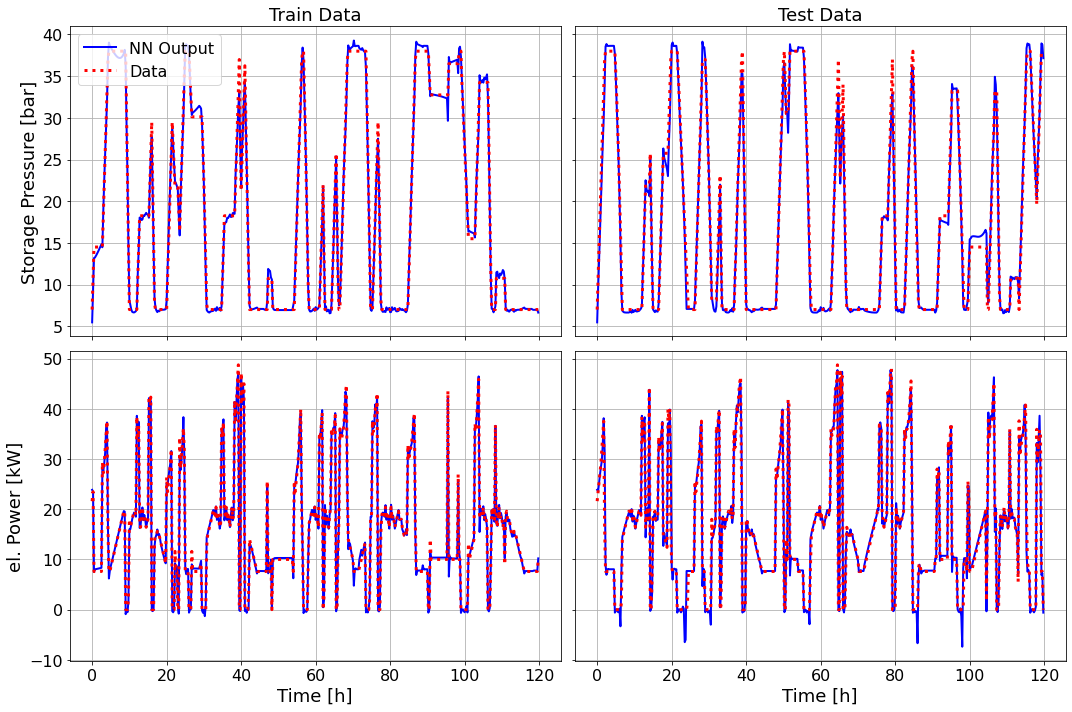

In [61]:
fig = plt.figure(figsize=(15,10))
ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222,sharey=ax0)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224,sharey=ax2)
fs=18
t = np.arange(0,480.0)/4 #480 timesteps in 15 Minute resolution
#Train Data
ax0.set_title('Train Data',fontsize=fs)
ax0.plot(t,y[0],color='b',lw=2,label='NN Output')
ax0.plot(t,Y[0],color='r',marker='None',linestyle=':',lw=3,markersize=8,label='Data')
ax0.tick_params(labelsize=fs-2)
ax0.legend(fontsize=fs-2,loc='upper left')
ax0.grid()
ax0.set_ylabel('Storage Pressure [bar]',fontsize=fs)
plt.setp(ax0.get_xticklabels(), visible=False)

ax2.plot(t,y[1],color='b',lw=2,label='NN Output')
ax2.plot(t,Y[1],color='r',marker='None',linestyle=':',lw=3,markersize=8,label='Train Data')
ax2.tick_params(labelsize=fs-2)
ax2.grid()
ax2.set_xlabel('Time [h]',fontsize=fs)
ax2.set_ylabel('el. Power [kW]',fontsize=fs)



#Test Data
ax1.set_title('Test Data',fontsize=fs)
ax1.plot(t,ytest[0],color='b',lw=2,label='NN Output')
ax1.plot(t,Ytest[0],color='r',marker='None',linestyle=':',lw=3,markersize=8,label='Test Data')
ax1.tick_params(labelsize=fs-2)
# ax1.legend(fontsize=fs-2,loc='upper left')
ax1.grid()
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), visible=False)

ax3.plot(t,ytest[1],color='b',lw=2,label='NN Output')
ax3.plot(t,Ytest[1],color='r',marker='None',linestyle=':',lw=3,markersize=8,label='Test Data')
ax3.tick_params(labelsize=fs-2)
ax3.grid()
ax3.set_xlabel('Time [h]',fontsize=fs)
plt.setp(ax3.get_yticklabels(), visible=False)

fig.tight_layout()
plt.show()


In [115]:
def acc(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return float(correct)/y_true.shape[0]

print('accuracy = ', acc(y,ytest))

accuracy =  2.0


In [118]:
def my_confusion_matrix(y_true, y_pred):
    N = np.unique(y_true).shape[0] # number of classes 
    cm = np.zeros((N, N))
    for n in range(y_true.shape[0]):
        cm[y_true[n], y_pred[n]] += 1
    return cm 

cnf_matrix = my_confusion_matrix(ytest, y)


IndexError: arrays used as indices must be of integer (or boolean) type